## Imports

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import ipywidgets as widgets

import os

import pickle


---

## 🔢 Feature Extraction

<!-- TODO: Explain -->

| Model               | Best Feature Extraction Method |
| :------------------ | :----------------------------- |
| Random Forest       | TF-IDF + Chi-Square            |
| Logistic Regression | TF-IDF + Information Gain      |
| Gradient Boosting   | GloVe + PCA                    |
<!-- | SVM                 | TF-IDF + BoW                   |
| DistilBERT          | Fine-tuned BERT embeddings     | -->


In [2]:
final_train_df = pd.read_csv("dataset_and_corpora/augmented_train_senti.csv")


In [3]:
def save_vectorizer(model, filename, folder="vectorizers"):
    """Save a model or object to the specified folder."""
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
    print(f"[INFO] Saved model to {filepath}")


### TF-IDF Feature Extarction

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus).


In [4]:
def extract_tfidf_features(df: pd.DataFrame, max_features: int = 5000) -> csr_matrix:
    """
    Extract TF-IDF features from the 'content' column of the DataFrame.

    :param df: Input DataFrame with a 'content' column
    :param max_features: Maximum number of features to extract
    :return: TF-IDF features as a sparse matrix
    """

    progress = widgets.IntProgress(value=0, min=0, max=1, description="TF-IDF:")
    display(progress)

    df["content"] = df["content"].fillna("")
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_features = csr_matrix(vectorizer.fit_transform(df["content"]))
    save_vectorizer(vectorizer, "final_tfidf_vectorizer.pkl")

    progress.value = 1
    return tfidf_features


#### Chi-Square Feature Extraction

=yes()

In [5]:
def extract_chi2_features(
    tfidf_features: csr_matrix, labels: np.ndarray, k: int = 5000
) -> csr_matrix:
    """
    Extract top k features using the Chi-Square test.

    :param tfidf_features: TF-IDF features as a sparse matrix
    :param labels: Labels corresponding to the features
    :param k: Number of top features to select
    :return: Reduced feature set as a sparse matrix
    """
    progress = widgets.IntProgress(value=0, min=0, max=1, description="Chi2:")
    display(progress)

    chi2_selector = SelectKBest(chi2, k=k)
    chi2_features = csr_matrix(chi2_selector.fit_transform(tfidf_features, labels))

    save_vectorizer(chi2_selector, "final_chi2_selector.pkl")
    progress.value = 1
    return chi2_features


#### Bag of Words Feature Extraction

=yes()

In [6]:
def extract_bow_features(tfidf_vectorizer: TfidfVectorizer, df: pd.DataFrame):
    """
    Extract Bag of Words (BoW) features based on the vocabulary of a fitted TF-IDF vectorizer.
    """

    progress = widgets.IntProgress(value=0, min=0, max=1, description="BoW:")
    display(progress)

    df["content"] = df["content"].fillna("")

    bow_vectorizer = CountVectorizer(vocabulary=tfidf_vectorizer.vocabulary_)

    bow_features = bow_vectorizer.fit_transform(df["content"])

    save_vectorizer(bow_vectorizer, "final_bow_vectorizer.pkl")

    progress.value = 1
    return bow_features


#### Information Gain Feature Extraction

=yes()

In [7]:
def extract_information_gain_features(
    tfidf_features: csr_matrix, labels: np.ndarray, k: int = 5000
) -> np.ndarray:
    """
    Extract top k features using Information Gain (Mutual Information)
    and return (reduced features as array, fitted SelectKBest object).
    """
    progress = widgets.IntProgress(value=0, min=0, max=1, description="InfoGain:")
    display(progress)

    labels = labels.astype(int)

    infogain_selector = SelectKBest(score_func=mutual_info_classif, k=k)
    reduced_features = infogain_selector.fit_transform(tfidf_features, labels)

    save_vectorizer(infogain_selector, "final_infogain_selector.pkl")

    progress.value = 1
    return reduced_features


### GloVe Feature Extraction

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

**Introduced in** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf).

Before running the cell, please download and move the pre-trained word vectors (Wikipedia 2014 + Gigaword 5) from [here](https://nlp.stanford.edu/data/glove.6B.zip) to the `datasets_and_corpora` folder

In [8]:
def extract_glove_features(
    df: pd.DataFrame,
    glove_path: str = "dataset_and_corpora/glove.6B.100d.txt",
    embedding_dim: int = 100,
) -> np.ndarray:
    """
    Extract GloVe features from the 'content' column of the DataFrame.

    :param df: Input DataFrame with a 'content' column
    :param glove_path: Path to the GloVe embeddings file
    :param embedding_dim: Dimension of the GloVe embeddings
    :return: GloVe features as a NumPy array
    """
    progress = widgets.IntProgress(value=0, min=0, max=len(df), description="GloVe:")
    display(progress)

    # Load GloVe embeddings
    glove_embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_embeddings[word] = vector

    # Compute sentence embeddings
    sentences = [content.split() for content in df["content"]]
    glove_features = np.array(
        [
            np.mean(
                [
                    glove_embeddings[word]
                    for word in sentence
                    if word in glove_embeddings
                ]
                or [np.zeros(embedding_dim, dtype="float32")],
                axis=0,
            )
            for sentence in sentences
        ]
    )

    for _ in range(len(df)):
        progress.value += 1

    return glove_features


#### PCA Feature Extraction

=yes()

In [9]:
def perform_pca(features: np.ndarray, n_components: int = 100) -> np.ndarray:
    """
    Perform PCA on the given features to reduce dimensionality.

    :param features: Input features as a NumPy array
    :param n_components: Number of principal components to retain
    :return: Reduced features as a NumPy array
    """
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    save_vectorizer(pca, "final_pca_model.pkl")

    return reduced_features


---

## 🌳 Random Forest

A Random Forest is a powerful ensemble machine learning algorithm that builds and aggregates the predictions of multiple [decision trees](https://scikit-learn.org/stable/modules/tree.html) to improve accuracy, robustness, and generalization. It is especially effective for classification tasks such as fake news detection, where complex patterns and high-dimensional feature spaces are common. In this implementation, we use scikit-learn’s [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with `n_estimators=100`, meaning the ensemble consists of 100 individual decision trees

The following code performs:
1. _[Feature Loading](#loading-tf-idf--chi-square-features):_ Loading the preprocessed features ([TF-IDF vectors selected by Chi-Squared test](#chi-square-feature-extraction))
2. _[K-Fold Cross-Validation](#test-rf-with-k-fold-cross-validation):_ Uses 5-fold cross-validation to evaluate the models performance.
3. _Ensemble Predictions:_ Store the predictions (in [`predictions/rf_ensemble_predictions.pkl`](predictions/rf_ensemble_predictions.pkl)) of all folds to enable the ensemble analysis.
4. _[Final Model](#train-rf-on-training-set):_ A final Random Forest model is trained on the entire testing set and saves the final trained model (in [`models/rf_model.pkl`](models/rf_model.pkl)) for future use.

### Loading TF-IDF + Chi-Square Features

In [10]:
labels = final_train_df["label"].to_numpy()


### Test RF with K-Fold Cross-Validation

In [11]:
def rf_KCross_Val(name, features):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    ensemble_predictions = np.zeros((features.shape[0], len(np.unique(labels))))
    print(f"Running {name} with {k}-fold cross-validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
        print(f"Fold {fold + 1}/{k}")

        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)

        ensemble_predictions[test_idx] = y_pred_proba
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)

        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))

    print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f}")

    with open(f"predictions/rf_w_{name}_ensemble_predictions.pkl", "wb") as file:
        pickle.dump(ensemble_predictions, file)


### Train RF on Training Set

In [13]:
def rf_final_model(name, features):
    """
    Train a final Random Forest model on the entire dataset and save it.
    """
    print(f"Training final Random Forest model with {name}...")
    final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    final_rf_model.fit(features, labels)

    # Save the final trained model
    with open(f"models/{name}_rf_model.pkl", "wb") as file:
        pickle.dump(final_rf_model, file)

    print("Final Random Forest model trained on the full dataset and saved!")


In [ ]:
# with open("features/tfidf_chi2_features.pkl", "rb") as file:
#     features = pickle.load(file)

# # No need to convert to a dense array; work with the sparse matrix directly
# if not isinstance(features, csr_matrix):
#     features = csr_matrix(features)

# rf_KCross_Val("tfidf_chi2", features)
# rf_final_model("tfidf_chi2", features)
# del features

with open("features/tfidf_info_gain_features.pkl", "rb") as file:
    features = pickle.load(file)
# No need to convert to a dense array; work with the sparse matrix directly
# Ensure the features remain in sparse format
if not issparse(features):
    features = csr_matrix(features)
rf_KCross_Val("tfidf_infogain", features)
rf_final_model("tfidf_infogain", features)
del features


In [14]:
with open("features/tfidf_bow_features.pkl", "rb") as file:
    features = pickle.load(file)
if not isinstance(features, csr_matrix):
    features = csr_matrix(features)

# Perform cross-validation on the entire dataset
# rf_KCross_Val("tfidf_bow", features)
rf_final_model("tfidf_bow", features)
del features


Training final Random Forest model with tfidf_bow...
Final Random Forest model trained on the full dataset and saved!


In [ ]:
with open("features/glove_pca_features.pkl", "rb") as file:
    features = pickle.load(file)
if not isinstance(features, csr_matrix):
    features = csr_matrix(features)

rf_KCross_Val("glove_pca", features)
rf_final_model("glove_pca", features)
del features


# 4. 🍎 Testing Testing



## Test Set Feature Extraction

In [15]:
class TestFeatureExtractor:
    def __init__(self):
        """Load all pre-fitted vectorizers, selectors, and models needed for test feature extraction."""
        print("[INFO] Loading feature extractors...")

        # Load TF-IDF Vectorizer
        with open("vectorizers/final_tfidf_vectorizer.pkl", "rb") as f:
            self.tfidf_vectorizer = pickle.load(f)

        # Load Chi2 Selector
        with open("vectorizers/final_chi2_selector.pkl", "rb") as f:
            self.chi2_selector = pickle.load(f)

        # Load BoW Vectorizer
        with open("vectorizers/final_bow_vectorizer.pkl", "rb") as f:
            self.bow_vectorizer = pickle.load(f)

        # Load InfoGain Selector
        with open("vectorizers/final_infogain_selector.pkl", "rb") as f:
            self.infogain_selector = pickle.load(f)

        # Load GloVe Embeddings (correct way)
        self.glove_embeddings = self.load_glove_embeddings(
            "dataset_and_corpora/glove.6B.100d.txt"
        )

        # Load PCA model for GloVe
        with open("vectorizers/final_pca_model.pkl", "rb") as f:
            self.pca_model = pickle.load(f)

    def load_glove_embeddings(self, glove_file_path):
        """Load GloVe embeddings from a text file into a dictionary."""
        print("[INFO] Loading GloVe embeddings...")
        embeddings = {}
        with open(glove_file_path, "r", encoding="utf-8") as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                vector = np.asarray(values[1:], dtype=np.float32)
                embeddings[word] = vector
        print(f"[INFO] Loaded {len(embeddings)} word vectors from GloVe.")
        return embeddings

    def transform_tfidf(self, df):
        """Transform data using pre-fitted TF-IDF vectorizer."""
        return self.tfidf_vectorizer.transform(df["content"])

    def transform_bow(self, df, max_features=5000):
        """Transform data using pre-fitted BoW vectorizer."""
        bow_matrix = self.bow_vectorizer.transform(df["content"])
        return bow_matrix.toarray()[:, :max_features]

    def transform_chi2(self, tfidf_features):
        """Transform data using Chi2 selector."""
        return self.chi2_selector.transform(tfidf_features)

    def transform_infogain(self, tfidf_features):
        """Transform data using InfoGain selector."""
        return self.infogain_selector.transform(tfidf_features)

    def transform_glove(self, df, embedding_dim=100):
        """Extract GloVe sentence embeddings."""
        sentences = [content.split() for content in df["content"]]
        glove_features = np.array(
            [
                np.mean(
                    [
                        self.glove_embeddings.get(word, np.zeros(embedding_dim))
                        for word in sentence
                    ]
                    or [np.zeros(embedding_dim)],
                    axis=0,
                )
                for sentence in sentences
            ]
        )
        return glove_features

    def transform_pca_on_glove(self, glove_features):
        """Reduce GloVe embeddings using pre-fitted PCA."""
        return self.pca_model.transform(glove_features)

    def extract_all_features(self, df):
        """Main function to transform test data for all models."""
        tfidf_features = self.transform_tfidf(df)

        features = {
            "bow": self.transform_bow(df),
            "chi2": self.transform_chi2(tfidf_features),
            "infogain": self.transform_infogain(tfidf_features),
        }

        glove_features = self.transform_glove(df)
        glove_pca_features = self.transform_pca_on_glove(glove_features)
        features["glove_pca"] = glove_pca_features

        return features


In [16]:
test_df = pd.read_csv("dataset_and_corpora/cleaned_test.csv")

feature_extractor = TestFeatureExtractor()

test_labels = pd.read_csv("dataset_and_corpora/cleaned_test.csv")["label"].to_numpy()

features = feature_extractor.extract_all_features(test_df)


[INFO] Loading feature extractors...
[INFO] Loading GloVe embeddings...
[INFO] Loaded 400000 word vectors from GloVe.


## Loading Models an Stroing Features

In [17]:
with open("models/tfidf_chi2_rf_model.pkl", "rb") as f:
    rf_model_tfidf_chi2 = pickle.load(f)
with open("models/tfidf_info_gain_rf_model.pkl", "rb") as f:
    rf_model_tfidf_infogain = pickle.load(f)
with open("models/tfidf_bow_rf_model.pkl", "rb") as f:
    rf_model_tfidf_bow = pickle.load(f)
# with open("models/glove_pca_rf_model.pkl", "rb") as f:
# rf_model_glove_pca = pickle.load(f)

X_chi2 = features["chi2"]
X_infogain = features["infogain"]
X_bow = features["bow"]
X_glove_pca = features["glove_pca"]
y_true = test_df["label"].to_numpy()


## Individual Model Evaluation Function

In [20]:
def evaluate_model(name, y_true, y_pred):
    """Evaluate the performance of a model."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} Evaluation ===")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", matrix)

    # Save textual metrics
    with open(f"evaluations/{name}_metrics.txt", "w") as f:
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(str(report))
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(matrix))

    print(f"[INFO] Saved metrics to {name}_metrics.txt\n")

    # Plot and save confusion matrix with percentages
    cm_percent = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis] * 100
    annot = np.array([[f"{val:.2f}%" for val in row] for row in cm_percent])

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_percent,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=True,
        xticklabels=["Pred Fake", "Pred True"],
        yticklabels=["Actual Fake", "Actual True"],
    )
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    plt.title(f"{name}", pad=40)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"assets/confusion_matrix_{name}.png")
    plt.show()



=== Random Forest with TF-IDF+Chi2 Evaluation ===
Accuracy: 0.9409
F1 Score: 0.9414
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7089
           1       0.94      0.94      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Confusion Matrix:
 [[6664  425]
 [ 419 6784]]
[INFO] Saved metrics to Random Forest with TF-IDF+Chi2_metrics.txt



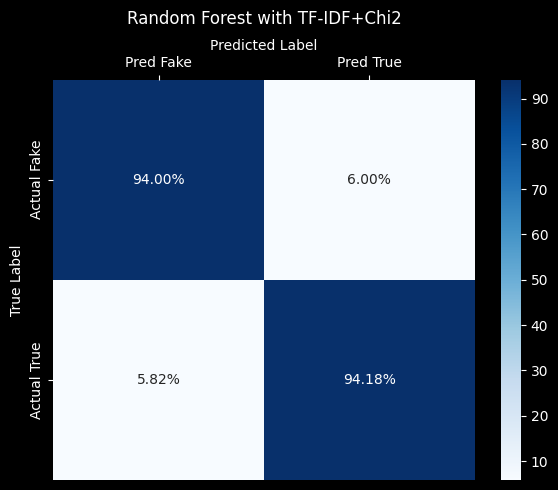


=== Random Forest with TF-IDF+Information Gain Evaluation ===
Accuracy: 0.9409
F1 Score: 0.9414
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7089
           1       0.94      0.94      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Confusion Matrix:
 [[6664  425]
 [ 419 6784]]
[INFO] Saved metrics to Random Forest with TF-IDF+Information Gain_metrics.txt



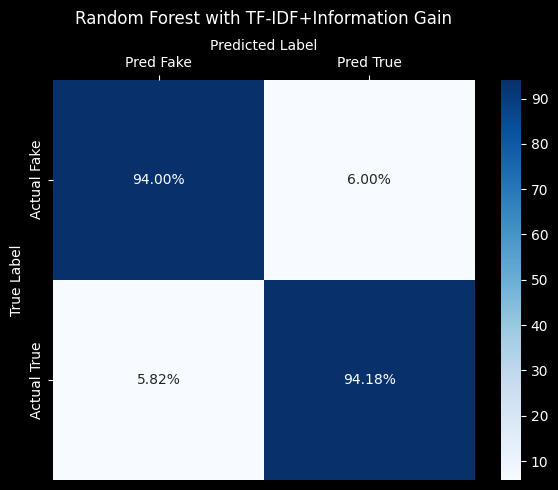


=== Random Forest with TF-IDF+BoW Evaluation ===
Accuracy: 0.9408
F1 Score: 0.9407
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7089
           1       0.95      0.93      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Confusion Matrix:
 [[6731  358]
 [ 488 6715]]
[INFO] Saved metrics to Random Forest with TF-IDF+BoW_metrics.txt



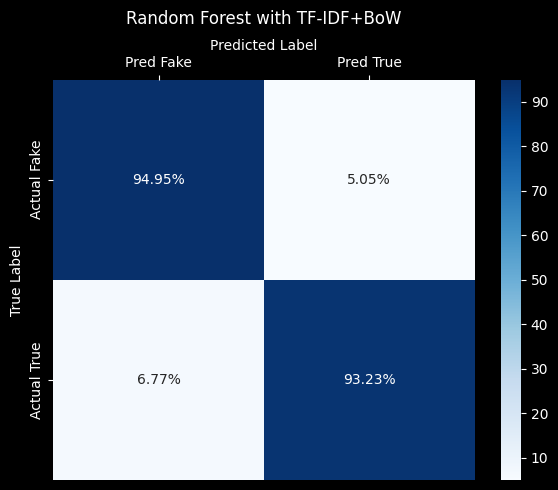

In [21]:
# === Random Forest with Chi-Square===
y_pred_rf = rf_model_tfidf_chi2.predict(X_chi2)
evaluate_model("Random Forest with TF-IDF+Chi2", y_true, y_pred_rf)

#  === Random Forest with Info Gain ===
y_pred_rf_infogain = rf_model_tfidf_infogain.predict(X_infogain)
evaluate_model("Random Forest with TF-IDF+Information Gain", y_true, y_pred_rf_infogain)

# === Random Forest with GloVe PCA ===
# y_pred_rf_glove_pca = rf_model_glove_pca.predict(X_glove_pca)
# evaluate_model("Random Forest with GloVe+PCA", y_true, y_pred_rf_glove_pca)

# === Random Forest with BoW ===
y_pred_rf_bow = rf_model_tfidf_bow.predict(X_bow)
evaluate_model("Random Forest with TF-IDF+BoW", y_true, y_pred_rf_bow)
